# Творческое задание

# (1) Аннуализация

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import scipy.stats as sts
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_excel("Data.xlsx")

df

,Year,Q,"CPI, %","core CPI, %","inf exp,%","real GDP growth, %","real GDP gap, %","BCI, %"
0,1999,Q4,1.1,0.400,1.500000,4.3,0.522266,1300
1,2000,Q1,0.8,0.100,2.300000,4.9,1.191745,900
2,2000,Q2,0.6,0.001,2.400000,5.1,0.599596,-200
3,2000,Q3,0.8,0.001,2.200000,4.1,0.241793,-1000
4,2000,Q4,1.0,0.300,2.300000,3.3,-0.150330,-900
...,...,...,...,...,...,...,...,...
94,2023,Q2,8.4,6.900,3.500000,0.5,3.238384,-200
95,2023,Q3,6.7,6.400,3.580106,0.3,2.511903,600
96,2023,Q4,4.2,5.300,3.266044,-0.3,1.077969,-1500
97,2024,Q1,3.5,4.600,3.033214,0.3,1.039421,-300


In [ ]:
def annualize(row, indicator):

    row[indicator] = ((1 + (row[indicator] / 100)) ** 4 - 1) * 100

    return row

#применяем функцию построчно
df_an = df.apply(annualize, axis = 1, indicator = ['CPI, %', 'core CPI, %', 'inf exp,%', 'real GDP growth, %', "BCI, %"])

#результат
df_an

,Year,Q,"CPI, %","core CPI, %","inf exp,%","real GDP growth, %","real GDP gap, %","BCI, %"
0,1999,Q4,4.473134,1.609626,6.136355,18.341545,0.522266,3841500.0
1,2000,Q1,3.238605,0.400600,9.522295,21.088236,1.191745,999900.0
2,2000,Q2,2.421687,0.004000,9.951163,22.014337,0.599596,0.0
3,2000,Q3,3.238605,0.004000,9.094683,17.436451,0.241793,656000.0
4,2000,Q4,4.060401,1.205411,9.522295,13.867893,-0.150330,409500.0
...,...,...,...,...,...,...,...,...
94,2023,Q2,38.075660,30.590270,14.752300,2.015050,3.238384,0.0
95,2023,Q3,29.615720,28.164135,15.107974,1.205411,2.511903,240000.0
96,2023,Q4,17.888346,22.945740,13.718246,-1.194611,1.077969,3841500.0
97,2024,Q1,14.752300,19.708982,12.696126,1.205411,1.039421,1500.0


# Выбор периодов исследования

Посмотрим на динамику показателей для разбиения временных рядов на периоды

<Figure size 2000x1200 with 0 Axes>

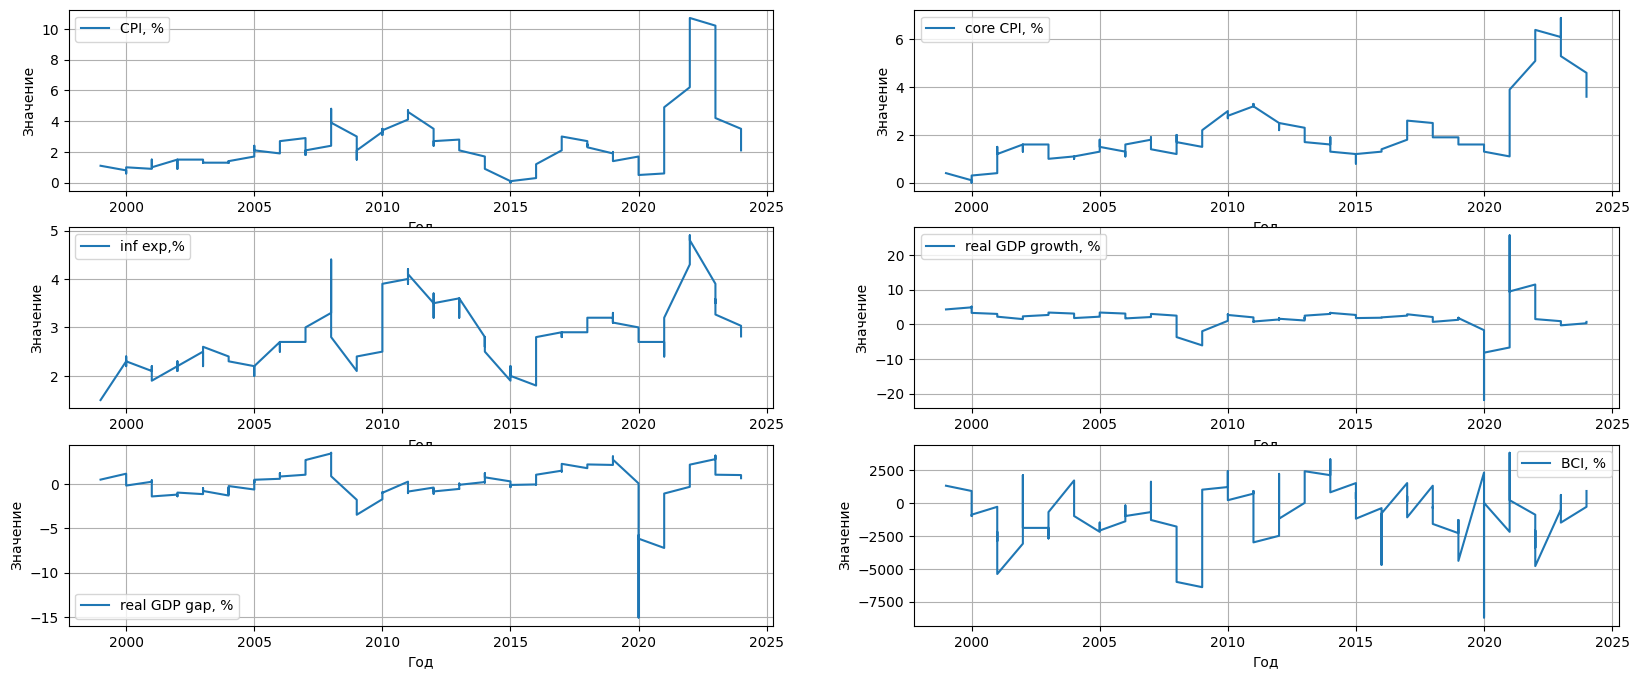

In [ ]:
columns = ['CPI, %', 'core CPI, %', 'inf exp,%', 'real GDP growth, %', 'real GDP gap, %', 'BCI, %']
num_indicators = 6

n_cols = 2
n_rows = (num_indicators + n_cols - 1) // n_cols
plt.figure(figsize=(20, 12))

# Создайте график
plt.figure(figsize=(20,8))  # Установите размер графика

# Итерируйте по столбцам для построения графика
for i, column in enumerate(columns):
    plt.subplot(n_rows, n_cols, i+1)

    plt.plot(df['Year'], df[column], label=column)

    plt.xlabel('Год')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)

plt.show()

**Периоды**:
1. 1999-2007: *период стабильного роста и развития экономики*
2. 2008-2015: *мировой финансовый кризис и восстановление экономики*
4. 2016-2019: *Брекзит и восстановление экономики*
5. 2020-2024: *COVID-19 и восстановление экономики*

In [ ]:
#разобьем аннуализированный датасет на периоды:
df_an_1 = df_an.iloc[0:33]
df_an_2 = df_an.iloc[33:65]
df_an_3 = df_an.iloc[65:81]
df_an_4 = df_an.iloc[81:99]

В дальнейшей работе будем использовать данные датасеты для оценки спецификаций в разные периоды

# (2) Основные описательные статистики найденных временных рядов

In [ ]:
metrics = {'Statistic': ['Minimum', 'Maximum', 'Median', 'Mode', 'Mean', 'Standard Deviation', 'Skewness'],}

values = df_an.columns[2:]

for i in values:
    metrics[i] = [
        df_an[i].min(),
        df_an[i].max(),
        df_an[i].median(),
        df_an[i].mode()[0],  # берем первую моду
        df_an[i].mean(),
        df_an[i].std(),
        df_an[i].skew()
    ]

# Создадим соответствующую таблицу

df_metrics = pd.DataFrame(metrics)
df_metrics

,Statistic,"CPI, %","core CPI, %","inf exp,%","real GDP growth, %","real GDP gap, %","BCI, %"
0,Minimum,0.008000,0.004000,6.136355,-62.794758,-15.078800,-1.000000e+02
1,Maximum,50.172525,30.590270,21.088236,149.655484,3.559700,5.470082e+09
2,Median,8.668324,6.555245,11.245326,8.668324,0.190542,2.856000e+06
3,Mode,8.668324,5.302282,9.094683,10.381289,-15.078800,0.000000e+00
4,Mean,10.736029,8.749609,11.961678,8.331290,-0.019932,1.230649e+08
5,Standard Deviation,9.706434,6.314379,3.142832,19.944841,2.427629,5.871367e+08
6,Skewness,2.382329,1.895901,0.875131,3.162093,-2.864983,8.103332e+00


# (3) Спецификация 1 (regression forecast ) & спецификация 2 (naive forecast) для совокупной инфляции

# Спецификация 1

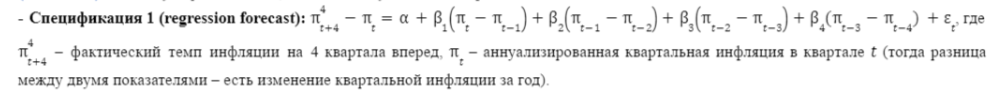

In [ ]:
df_CPI=df_an[["Year", "Q", "CPI, %"]]
df_CPI['(p_t - p_(t-1))'] = None
df_CPI['(p_(t-1) - p_(t-2))'] = None
df_CPI['(p_(t-2) - p_(t-3))'] = None
df_CPI['(p_(t-3) - p_(t-4))'] = None

for i in range(4, len(df_CPI)):
    df_CPI.loc[df_CPI.index[i], '(p_t - p_(t-1))'] = df_CPI['CPI, %'].iloc[i] - df_CPI['CPI, %'].iloc[i - 1]
    df_CPI.loc[df_CPI.index[i], '(p_(t-1) - p_(t-2))'] = df_CPI['CPI, %'].iloc[i - 1] - df_CPI['CPI, %'].iloc[i - 2]
    df_CPI.loc[df_CPI.index[i], '(p_(t-2) - p_(t-3))'] = df_CPI['CPI, %'].iloc[i - 2] - df_CPI['CPI, %'].iloc[i - 3]
    df_CPI.loc[df_CPI.index[i], '(p_(t-3) - p_(t-4))'] = df_CPI['CPI, %'].iloc[i - 3] - df_CPI['CPI, %'].iloc[i - 4]

df_CPI

,Year,Q,"CPI, %",(p_t - p_(t-1)),(p_(t-1) - p_(t-2)),(p_(t-2) - p_(t-3)),(p_(t-3) - p_(t-4))
0,1999,Q4,4.473134,None,None,None,None
1,2000,Q1,3.238605,None,None,None,None
2,2000,Q2,2.421687,None,None,None,None
3,2000,Q3,3.238605,None,None,None,None
4,2000,Q4,4.060401,0.821796,0.816919,-0.816919,-1.234529
...,...,...,...,...,...,...,...
94,2023,Q2,38.075660,-9.402047,-2.694818,3.762525,4.212961
95,2023,Q3,29.615720,-8.45994,-9.402047,-2.694818,3.762525
96,2023,Q4,17.888346,-11.727374,-8.45994,-9.402047,-2.694818
97,2024,Q1,14.752300,-3.136046,-11.727374,-8.45994,-9.402047


В полученном датафрейме в каждой строке для соответствующего года и квартиля CPI, % соответствует p_t(аннуализированной квартальной инфляции в квартале t) и заданы значения p_t - p_(t-1), p_(t-1) - p_(t-2), p_(t-2) - p_(t-3), p_(t-3) - p_(t-4).

Создадим столбец p4_(t+4) - p_t

In [ ]:
df_CPI.set_index('Q', inplace=True)
df_CPI['p_(t+4)-p_t'] = df_CPI['CPI, %'].shift(-4) - df_CPI['CPI, %']
df_CPI

,Year,"CPI, %",(p_t - p_(t-1)),(p_(t-1) - p_(t-2)),(p_(t-2) - p_(t-3)),(p_(t-3) - p_(t-4)),p_(t+4)-p_t
Q,,,,,,,
Q4,1999,4.473134,None,None,None,None,-0.412733
Q1,2000,3.238605,None,None,None,None,0.410287
Q2,2000,2.421687,None,None,None,None,3.714669
Q3,2000,3.238605,None,None,None,None,2.897750
Q4,2000,4.060401,0.821796,0.816919,-0.816919,-1.234529,0.000000
...,...,...,...,...,...,...,...
Q2,2023,38.075660,-9.402047,-2.694818,3.762525,4.212961,-29.407336
Q3,2023,29.615720,-8.45994,-9.402047,-2.694818,3.762525,NaN
Q4,2023,17.888346,-11.727374,-8.45994,-9.402047,-2.694818,NaN


In [ ]:
df_CPI= df_CPI.apply(pd.to_numeric, errors='coerce')
df_CPI_sm=df_CPI.iloc[4:-4]
X= df_CPI_sm[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))"]]
X = sm.add_constant(X)
Y = df_CPI_sm['p_(t+4)-p_t']
model_1 = sm.OLS(Y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     6.651
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           0.000103
Time:                        12:27:53   Log-Likelihood:                -329.73
No. Observations:                  91   AIC:                             669.5
Df Residuals:                      86   BIC:                             682.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0635      1.002      1.061      0.291      -0.928       3.055
(p_t - p_(t-1))         1.0837      0.372      2.916      0.005       0.345       1.822
(p_(t-1) - p_(t-2))    -0.1532      0.427     -0.359      0.721      -1.003       0.696
(p_(t-2) - p_(t-3))    -0.9404      0.422     -2.227      0.029      -1.780      -0.101
(p_(t-3) - p_(t-4))    -0.7761      0.404     -1.921      0.058      -1.579       0.027
==============================================================================
Omnibus:                       18.620   Durbin-Watson:                   0.594
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.533
Skew:                           0.974   Prob(JB):                     4.71e-06
Kurtosis:                       4.637   Cond. No.                         4.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Спецификация 1 для каждого периода

In [ ]:
#период 1: 1999-2007
df_1CPI = df_CPI.iloc[0:33]

#оценка модели
df_1CPI= df_1CPI.apply(pd.to_numeric, errors='coerce')
df_1CPI_sm=df_1CPI.iloc[4:-4]
X= df_1CPI_sm[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))"]]
X = sm.add_constant(X)
Y = df_1CPI_sm['p_(t+4)-p_t']
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     3.557
Date:                Sun, 24 Nov 2024   Prob (F-statistic):             0.0239
Time:                        12:27:53   Log-Likelihood:                -45.534
No. Observations:                  25   AIC:                             101.1
Df Residuals:                      20   BIC:                             107.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.3122      0.398      3.301      0.004       0.483       2.141
(p_t - p_(t-1))        -1.0023      0.296     -3.382      0.003      -1.620      -0.384
(p_(t-1) - p_(t-2))    -0.7099      0.322     -2.206      0.039      -1.381      -0.039
(p_(t-2) - p_(t-3))    -0.1034      0.312     -0.332      0.743      -0.753       0.546
(p_(t-3) - p_(t-4))     0.0676      0.300      0.225      0.824      -0.559       0.694
==============================================================================
Omnibus:                        2.169   Durbin-Watson:                   0.631
Prob(Omnibus):                  0.338   Jarque-Bera (JB):                1.298
Skew:                           0.253   Prob(JB):                        0.523
Kurtosis:                       2.004   Cond. No.                         2.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#период 2: 2008-2015
df_2CPI = df_CPI.iloc[33:65]

#оценка модели
df_2CPI= df_2CPI.apply(pd.to_numeric, errors='coerce')
df_2CPI_sm=df_2CPI.iloc[4:-4]
X= df_2CPI_sm[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))"]]
X = sm.add_constant(X)
Y = df_2CPI_sm['p_(t+4)-p_t']
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                 -0.095
Method:                 Least Squares   F-statistic:                    0.4993
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.737
Time:                        12:27:53   Log-Likelihood:                -72.607
No. Observations:                  24   AIC:                             155.2
Df Residuals:                      19   BIC:                             161.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.7188      1.197     -1.435      0.167      -4.225       0.787
(p_t - p_(t-1))         0.3358      0.647      0.519      0.610      -1.018       1.689
(p_(t-1) - p_(t-2))    -0.7015      0.675     -1.040      0.311      -2.114       0.711
(p_(t-2) - p_(t-3))    -0.0738      0.542     -0.136      0.893      -1.209       1.061
(p_(t-3) - p_(t-4))     0.1128      0.479      0.235      0.816      -0.890       1.116
==============================================================================
Omnibus:                        1.678   Durbin-Watson:                   0.369
Prob(Omnibus):                  0.432   Jarque-Bera (JB):                1.452
Skew:                           0.476   Prob(JB):                        0.484
Kurtosis:                       2.262   Cond. No.                         3.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#период 3: 2016-2019
df_3CPI = df_CPI.iloc[65:81]

#оценка модели
df_3CPI= df_3CPI.apply(pd.to_numeric, errors='coerce')
df_3CPI_sm=df_3CPI.iloc[4:-4]
X= df_3CPI_sm[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))"]]
X = sm.add_constant(X)
Y = df_3CPI_sm['p_(t+4)-p_t']
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     2.471
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.242
Time:                        12:27:53   Log-Likelihood:                -10.702
No. Observations:                   8   AIC:                             31.40
Df Residuals:                       3   BIC:                             31.80
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.9268      0.753     -2.558      0.083      -4.324       0.470
(p_t - p_(t-1))         0.9080      0.397      2.287      0.106      -0.355       2.171
(p_(t-1) - p_(t-2))    -0.4096      0.501     -0.817      0.474      -2.005       1.186
(p_(t-2) - p_(t-3))     0.6955      0.549      1.268      0.294      -1.050       2.441
(p_(t-3) - p_(t-4))    -0.6443      0.506     -1.272      0.293      -2.256       0.967
==============================================================================
Omnibus:                        1.792   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.408   Jarque-Bera (JB):                0.882
Skew:                           0.432   Prob(JB):                        0.643
Kurtosis:                       1.623   Cond. No.                         5.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#период 4: 2020-2024
df_4CPI = df_CPI.iloc[81:99]

#оценка модели
df_4CPI= df_4CPI.apply(pd.to_numeric, errors='coerce')
df_4CPI_sm=df_4CPI.iloc[4:-4]
X= df_4CPI_sm[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))"]]
X = sm.add_constant(X)
Y = df_4CPI_sm['p_(t+4)-p_t']
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     11.61
Date:                Sun, 24 Nov 2024   Prob (F-statistic):            0.00959
Time:                        12:27:53   Log-Likelihood:                -35.570
No. Observations:                  10   AIC:                             81.14
Df Residuals:                       5   BIC:                             82.65
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  19.8951      6.154      3.233      0.023       4.075      35.715
(p_t - p_(t-1))         1.9888      0.859      2.314      0.069      -0.220       4.198
(p_(t-1) - p_(t-2))     0.4720      1.107      0.426      0.688      -2.375       3.319
(p_(t-2) - p_(t-3))    -3.6267      1.015     -3.574      0.016      -6.235      -1.018
(p_(t-3) - p_(t-4))    -2.3250      1.052     -2.210      0.078      -5.030       0.380
==============================================================================
Omnibus:                        0.461   Durbin-Watson:                   1.548
Prob(Omnibus):                  0.794   Jarque-Bera (JB):                0.506
Skew:                          -0.224   Prob(JB):                        0.776
Kurtosis:                       1.993   Cond. No.                         17.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Спецификация 2

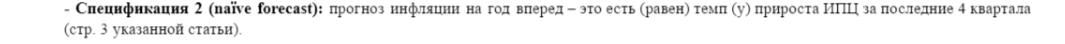

In [ ]:
df_CPI2=df_an[["Year", "Q", "CPI, %"]]
df_CPI2['Forecast'] = df_CPI2['CPI, %'].shift(1).rolling(window=4).mean()
df_CPI2

,Year,Q,"CPI, %",Forecast
0,1999,Q4,4.473134,NaN
1,2000,Q1,3.238605,NaN
2,2000,Q2,2.421687,NaN
3,2000,Q3,3.238605,NaN
4,2000,Q4,4.060401,3.343008
...,...,...,...,...
94,2023,Q2,38.075660,46.564318
95,2023,Q3,29.615720,45.533973
96,2023,Q4,17.888346,41.335403
97,2024,Q1,14.752300,33.264359


In [ ]:
r2 = r2_score(df_an.iloc[4:99]['CPI, %'], df_CPI2.iloc[4:99]['Forecast'])
round(r2, 3)

0.522

# Спецификация 2 для каждого периода

In [ ]:
#период 1:1999-2007
df_1CPI2 = df_CPI2.iloc[0:33]

r2 = r2_score(df_an_1.iloc[4:33]['CPI, %'], df_1CPI2.iloc[4:33]['Forecast'])
round(r2, 3)

0.539

In [ ]:
#период 2:2008-2015
df_2CPI2 = df_CPI2.iloc[33:65]

r2 = r2_score(df_an_2['CPI, %'], df_2CPI2['Forecast'])
round(r2, 3)

0.427

In [ ]:
#период 3:2016-2019
df_3CPI2 = df_CPI2.iloc[65:81]

r2 = r2_score(df_an_3['CPI, %'], df_3CPI2['Forecast'])
round(r2, 3)

0.199

In [ ]:
#период 4:2020-2024
df_4CPI2 = df_CPI2.iloc[81:99]

r2 = r2_score(df_an_4['CPI, %'], df_4CPI2['Forecast'])
round(r2, 3)

0.318

# (4) Оценка спецификации (для базовой инфляции) при помощи МНК + naive forecast

In [ ]:
df_core_CPI = df_an[['Year', 'Q', 'core CPI, %']]
df_core_CPI['(p_t - p_(t-1))'] = None
df_core_CPI['(p_(t-1) - p_(t-2))'] = None
df_core_CPI['(p_(t-2) - p_(t-3))'] = None
df_core_CPI['(p_(t-3) - p_(t-4))'] = None

for i in range(4, len(df_core_CPI)):
    df_core_CPI.loc[df_core_CPI.index[i], '(p_t - p_(t-1))'] = df_core_CPI['core CPI, %'].iloc[i] - df_core_CPI['core CPI, %'].iloc[i - 1]
    df_core_CPI.loc[df_core_CPI.index[i], '(p_(t-1) - p_(t-2))'] = df_core_CPI['core CPI, %'].iloc[i - 1] - df_core_CPI['core CPI, %'].iloc[i - 2]
    df_core_CPI.loc[df_core_CPI.index[i], '(p_(t-2) - p_(t-3))'] = df_core_CPI['core CPI, %'].iloc[i - 2] - df_core_CPI['core CPI, %'].iloc[i - 3]
    df_core_CPI.loc[df_core_CPI.index[i], '(p_(t-3) - p_(t-4))'] = df_core_CPI['core CPI, %'].iloc[i - 3] - df_core_CPI['core CPI, %'].iloc[i - 4]

df_core_CPI

,Year,Q,"core CPI, %",(p_t - p_(t-1)),(p_(t-1) - p_(t-2)),(p_(t-2) - p_(t-3)),(p_(t-3) - p_(t-4))
0,1999,Q4,1.609626,None,None,None,None
1,2000,Q1,0.400600,None,None,None,None
2,2000,Q2,0.004000,None,None,None,None
3,2000,Q3,0.004000,None,None,None,None
4,2000,Q4,1.205411,1.201411,0.0,-0.3966,-1.209025
...,...,...,...,...,...,...,...
94,2023,Q2,30.590270,3.865493,-1.439358,0.481141,1.435298
95,2023,Q3,28.164135,-2.426135,3.865493,-1.439358,0.481141
96,2023,Q4,22.945740,-5.218395,-2.426135,3.865493,-1.439358
97,2024,Q1,19.708982,-3.236758,-5.218395,-2.426135,3.865493


In [ ]:
df_core_CPI.set_index('Q', inplace=True)
df_core_CPI['p_(t+4)-p_t'] = df_core_CPI['core CPI, %'].shift(-4) - df_core_CPI['core CPI, %']
df_core_CPI

,Year,"core CPI, %",(p_t - p_(t-1)),(p_(t-1) - p_(t-2)),(p_(t-2) - p_(t-3)),(p_(t-3) - p_(t-4)),p_(t+4)-p_t
Q,,,,,,,
Q4,1999,1.609626,None,None,None,None,-0.404215
Q1,2000,0.400600,None,None,None,None,1.209025
Q2,2000,0.004000,None,None,None,None,4.469134
Q3,2000,0.004000,None,None,None,None,6.132355
Q4,2000,1.205411,1.201411,0.0,-0.3966,-1.209025,3.681682
...,...,...,...,...,...,...,...
Q2,2023,30.590270,3.865493,-1.439358,0.481141,1.435298,-15.393840
Q3,2023,28.164135,-2.426135,3.865493,-1.439358,0.481141,NaN
Q4,2023,22.945740,-5.218395,-2.426135,3.865493,-1.439358,NaN


In [ ]:
df_core_CPI= df_core_CPI.apply(pd.to_numeric, errors='coerce')
df_core_CPI_sm=df_core_CPI.iloc[4:-4]

X= df_core_CPI_sm[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))"]]
X = sm.add_constant(X)
Y = df_core_CPI_sm['p_(t+4)-p_t']

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.213
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.311
Time:                        12:27:54   Log-Likelihood:                -267.56
No. Observations:                  91   AIC:                             545.1
Df Residuals:                      86   BIC:                             557.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6916      0.514      1.345      0.182      -0.331       1.714
(p_t - p_(t-1))         0.4310      0.353      1.221      0.225      -0.270       1.132
(p_(t-1) - p_(t-2))     0.3310      0.402      0.824      0.412      -0.468       1.130
(p_(t-2) - p_(t-3))    -0.0506      0.417     -0.121      0.904      -0.879       0.778
(p_(t-3) - p_(t-4))    -0.4207      0.375     -1.122      0.265      -1.166       0.325
==============================================================================
Omnibus:                       27.450   Durbin-Watson:                   0.429
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.155
Skew:                           0.915   Prob(JB):                     1.19e-19
Kurtosis:                       7.431   Cond. No.                         2.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Спецификация базовой инфляции для каждого периода

In [ ]:
df1_core_CPI = df_core_CPI.iloc[0:33]

df1_core_CPI= df1_core_CPI.apply(pd.to_numeric, errors='coerce')
df1_core_CPI_sm=df1_core_CPI.iloc[4:-4]

X= df1_core_CPI_sm[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))"]]
X = sm.add_constant(X)
Y = df1_core_CPI_sm['p_(t+4)-p_t']

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                 -0.075
Method:                 Least Squares   F-statistic:                    0.5791
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.681
Time:                        12:27:54   Log-Likelihood:                -50.462
No. Observations:                  25   AIC:                             110.9
Df Residuals:                      20   BIC:                             117.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.7545      0.431      1.749      0.096      -0.145       1.655
(p_t - p_(t-1))        -0.3508      0.366     -0.959      0.349      -1.114       0.412
(p_(t-1) - p_(t-2))    -0.1328      0.389     -0.341      0.737      -0.945       0.680
(p_(t-2) - p_(t-3))    -0.0904      0.388     -0.233      0.818      -0.899       0.719
(p_(t-3) - p_(t-4))    -0.4063      0.380     -1.071      0.297      -1.198       0.385
==============================================================================
Omnibus:                        0.409   Durbin-Watson:                   0.570
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.464
Skew:                           0.263   Prob(JB):                        0.793
Kurtosis:                       2.590   Cond. No.                         1.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df2_core_CPI = df_core_CPI.iloc[33:65]

df2_core_CPI= df2_core_CPI.apply(pd.to_numeric, errors='coerce')
df2_core_CPI_sm=df2_core_CPI.iloc[4:-4]

X = df2_core_CPI_sm[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))"]]
X = sm.add_constant(X)
Y = df2_core_CPI_sm['p_(t+4)-p_t']

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1.471
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.250
Time:                        12:27:54   Log-Likelihood:                -57.519
No. Observations:                  24   AIC:                             125.0
Df Residuals:                      19   BIC:                             130.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.5707      0.612     -0.933      0.363      -1.851       0.710
(p_t - p_(t-1))         0.3346      0.508      0.658      0.518      -0.729       1.398
(p_(t-1) - p_(t-2))    -0.3908      0.539     -0.725      0.478      -1.520       0.738
(p_(t-2) - p_(t-3))     0.4435      0.513      0.864      0.398      -0.631       1.518
(p_(t-3) - p_(t-4))     0.7903      0.486      1.626      0.120      -0.227       1.807
==============================================================================
Omnibus:                        1.269   Durbin-Watson:                   0.472
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                0.885
Skew:                           0.461   Prob(JB):                        0.642
Kurtosis:                       2.813   Cond. No.                         1.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df3_core_CPI = df_core_CPI.iloc[65:81]

df3_core_CPI= df3_core_CPI.apply(pd.to_numeric, errors='coerce')
df3_core_CPI_sm=df3_core_CPI.iloc[4:-4]

X= df3_core_CPI_sm[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))"]]
X = sm.add_constant(X)
Y = df3_core_CPI_sm['p_(t+4)-p_t']

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                 -0.445
Method:                 Least Squares   F-statistic:                    0.4612
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.766
Time:                        12:27:54   Log-Likelihood:                -14.004
No. Observations:                   8   AIC:                             38.01
Df Residuals:                       3   BIC:                             38.41
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.9058      0.978     -0.926      0.423      -4.018       2.206
(p_t - p_(t-1))         0.4350      0.627      0.694      0.538      -1.561       2.431
(p_(t-1) - p_(t-2))    -0.5834      0.693     -0.842      0.462      -2.789       1.622
(p_(t-2) - p_(t-3))     0.0581      0.722      0.080      0.941      -2.240       2.357
(p_(t-3) - p_(t-4))    -0.6779      0.885     -0.766      0.500      -3.496       2.140
==============================================================================
Omnibus:                        5.909   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                1.803
Skew:                           1.132   Prob(JB):                        0.406
Kurtosis:                       3.532   Cond. No.                         2.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df4_core_CPI = df_core_CPI.iloc[81:99]

df4_core_CPI= df4_core_CPI.apply(pd.to_numeric, errors='coerce')
df4_core_CPI_sm=df4_core_CPI.iloc[4:-4]

X= df4_core_CPI_sm[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))"]]
X = sm.add_constant(X)
Y = df4_core_CPI_sm['p_(t+4)-p_t']

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     3.398
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.106
Time:                        12:27:54   Log-Likelihood:                -31.588
No. Observations:                  10   AIC:                             73.18
Df Residuals:                       5   BIC:                             74.69
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.2600      4.957      2.675      0.044       0.517      26.003
(p_t - p_(t-1))        -2.1907      1.472     -1.488      0.197      -5.975       1.593
(p_(t-1) - p_(t-2))     3.1143      1.508      2.065      0.094      -0.763       6.992
(p_(t-2) - p_(t-3))     0.1623      2.007      0.081      0.939      -4.996       5.321
(p_(t-3) - p_(t-4))    -4.7892      1.787     -2.680      0.044      -9.383      -0.196
==============================================================================
Omnibus:                        3.701   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                1.132
Skew:                           0.787   Prob(JB):                        0.568
Kurtosis:                       3.490   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Naive forecast

In [ ]:
#создадим столбец с суммой инфляции за прошедшие 4 квартала
df_core_CPI_naive = df_an[['Year', 'Q', 'core CPI, %']]
df_core_CPI_naive['naive forecast'] = df_core_CPI_naive['core CPI, %'].shift(1).rolling(window=4).mean()

df_core_CPI_naive

,Year,Q,"core CPI, %",naive forecast
0,1999,Q4,1.609626,NaN
1,2000,Q1,0.400600,NaN
2,2000,Q2,0.004000,NaN
3,2000,Q3,0.004000,NaN
4,2000,Q4,1.205411,0.504557
...,...,...,...,...
94,2023,Q2,30.590270,27.204901
95,2023,Q3,28.164135,28.290544
96,2023,Q4,22.945740,28.410829
97,2024,Q1,19.708982,27.106231


In [ ]:
r2 = r2_score(df_core_CPI_naive.iloc[4:99]['core CPI, %'], df_core_CPI_naive.iloc[4:99]['naive forecast'])
round(r2, 3)

0.732

# Naive forecast для каждого периода

In [ ]:
df1_core_CPI_naive = df_core_CPI_naive.iloc[0:33]

#считаем вручную, так как через функцию получается отрицательное значение
r = df_core_CPI_naive.iloc[4:33]['core CPI, %'].corr(df1_core_CPI_naive.iloc[4:33]['naive forecast'])
r2 = r**2

round(r2, 3)

0.331

In [ ]:
df2_core_CPI_naive = df_core_CPI_naive.iloc[33:65]

r2 = r2_score(df2_core_CPI_naive['core CPI, %'], df2_core_CPI_naive['naive forecast'])
round(r2, 3)

0.573

In [ ]:
df3_core_CPI_naive = df_core_CPI_naive.iloc[65:81]

#считаем вручную, так как через функцию получается отрицательное значение
r = df3_core_CPI_naive['core CPI, %'].corr(df3_core_CPI_naive['naive forecast'])
r2 = r**2

round(r2, 3)

0.301

In [ ]:
df4_core_CPI_naive = df_core_CPI_naive.iloc[81:99]

r2 = r2_score(df4_core_CPI_naive['core CPI, %'], df4_core_CPI_naive['naive forecast'])
round(r2, 3)

0.548

# (5) Спецификация 3 (для инфляционных ожиданий) & спецификация 4 (прогноз инфляции на год вперед)

# Спецификация 3

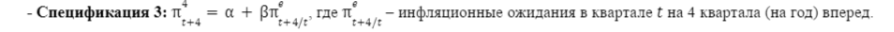

In [ ]:
#для оценки инфляции на Q1 2024 необходимо брать ИО за Q1 2023, так как ИО Q1 2023 - это ИО на Q1 2024

df_CPI_3 = df_an[['Year', 'Q', 'CPI, %', 'inf exp,%']]

df_CPI_3['Ep_(t-4)'] = df_CPI_3['inf exp,%'].shift(+4) #сдвинулись на 4 периода назад

df_CPI_3.head(7)

,Year,Q,"CPI, %","inf exp,%",Ep_(t-4)
0,1999,Q4,4.473134,6.136355,NaN
1,2000,Q1,3.238605,9.522295,NaN
2,2000,Q2,2.421687,9.951163,NaN
3,2000,Q3,3.238605,9.094683,NaN
4,2000,Q4,4.060401,9.522295,6.136355
5,2001,Q1,3.648892,8.668324,9.522295
6,2001,Q2,6.136355,8.668324,9.951163


In [ ]:
df_CPI_3 = df_CPI_3.apply(pd.to_numeric, errors='coerce')
df_CPI_3_sm = df_CPI_3.iloc[4:-4]

X = df_CPI_3_sm['Ep_(t-4)']
X = sm.add_constant(X)
Y = df_CPI_3_sm['CPI, %']

model_3 = sm.OLS(Y, X).fit()

model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CPI, %   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     8.961
Date:                Sun, 24 Nov 2024   Prob (F-statistic):            0.00357
Time:                        12:30:35   Log-Likelihood:                -331.64
No. Observations:                  91   AIC:                             667.3
Df Residuals:                      89   BIC:                             672.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0868      4.075     -0.267      0.790      -9.184       7.011
Ep_(t-4)       1.0185      0.340      2.994      0.004       0.342       1.694
==============================================================================
Omnibus:                       59.665   Durbin-Watson:                   0.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.862
Skew:                           2.266   Prob(JB):                     2.98e-48
Kurtosis:                       9.098   Cond. No.                         50.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Спецификация 3 для каждого периода

In [ ]:
df1_CPI_3 = df_CPI_3.iloc[0:33]

df1_CPI_3 = df1_CPI_3.apply(pd.to_numeric, errors='coerce')
df1_CPI_3_sm = df1_CPI_3.iloc[4:-4]

X = df1_CPI_3_sm['Ep_(t-4)']
X = sm.add_constant(X)
Y = df1_CPI_3_sm['CPI, %']

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CPI, %   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.3077
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.584
Time:                        12:27:55   Log-Likelihood:                -53.531
No. Observations:                  25   AIC:                             111.1
Df Residuals:                      23   BIC:                             113.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9560      4.492      0.881      0.388      -5.335      13.247
Ep_(t-4)       0.2711      0.489      0.555      0.584      -0.740       1.282
==============================================================================
Omnibus:                        3.002   Durbin-Watson:                   0.444
Prob(Omnibus):                  0.223   Jarque-Bera (JB):                2.484
Skew:                           0.752   Prob(JB):                        0.289
Kurtosis:                       2.654   Cond. No.                         97.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df2_CPI_3 = df_CPI_3.iloc[33:65]

df2_CPI_3 = df2_CPI_3.apply(pd.to_numeric, errors='coerce')
df2_CPI_3_sm = df2_CPI_3.iloc[4:-4]

X = df2_CPI_3_sm['Ep_(t-4)']
X = sm.add_constant(X)
Y = df2_CPI_3_sm['CPI, %']

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CPI, %   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     2.322
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.142
Time:                        12:27:55   Log-Likelihood:                -68.136
No. Observations:                  24   AIC:                             140.3
Df Residuals:                      22   BIC:                             142.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.5172      4.521      4.096      0.000       9.141      27.894
Ep_(t-4)      -0.4731      0.311     -1.524      0.142      -1.117       0.171
==============================================================================
Omnibus:                        1.418   Durbin-Watson:                   0.250
Prob(Omnibus):                  0.492   Jarque-Bera (JB):                0.896
Skew:                           0.471   Prob(JB):                        0.639
Kurtosis:                       2.909   Cond. No.                         75.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df3_CPI_3 = df_CPI_3.iloc[65:81]

df3_CPI_3 = df3_CPI_3.apply(pd.to_numeric, errors='coerce')
df3_CPI_3_sm = df3_CPI_3.iloc[4:-4]

X = df3_CPI_3_sm['Ep_(t-4)']
X = sm.add_constant(X)
Y = df3_CPI_3_sm['CPI, %']

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CPI, %   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                 -0.115
Method:                 Least Squares   F-statistic:                    0.2802
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.616
Time:                        12:27:55   Log-Likelihood:                -12.494
No. Observations:                   8   AIC:                             28.99
Df Residuals:                       6   BIC:                             29.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2059      2.779      3.313      0.016       2.407      16.005
Ep_(t-4)       0.1381      0.261      0.529      0.616      -0.500       0.776
==============================================================================
Omnibus:                        1.758   Durbin-Watson:                   1.018
Prob(Omnibus):                  0.415   Jarque-Bera (JB):                0.718
Skew:                           0.063   Prob(JB):                        0.698
Kurtosis:                       1.538   Cond. No.                         63.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df4_CPI_3 = df_CPI_3.iloc[81:99]

df4_CPI_3 = df4_CPI_3.apply(pd.to_numeric, errors='coerce')
df4_CPI_3_sm = df4_CPI_3.iloc[4:-4]

X = df4_CPI_3_sm['Ep_(t-4)']
X = sm.add_constant(X)
Y = df4_CPI_3_sm['CPI, %']

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CPI, %   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.9265
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.364
Time:                        12:27:55   Log-Likelihood:                -41.872
No. Observations:                  10   AIC:                             87.74
Df Residuals:                       8   BIC:                             88.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3771     24.714      0.258      0.803     -50.613      63.367
Ep_(t-4)       1.7613      1.830      0.963      0.364      -2.458       5.981
==============================================================================
Omnibus:                        1.373   Durbin-Watson:                   0.305
Prob(Omnibus):                  0.503   Jarque-Bera (JB):                0.726
Skew:                          -0.125   Prob(JB):                        0.696
Kurtosis:                       1.704   Cond. No.                         59.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Спецификация 4

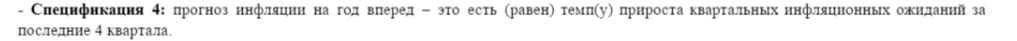

In [ ]:
df_CPI_4 = df_an[['Year', 'Q', 'CPI, %', 'inf exp,%']]
df_CPI_4['Ep_(t-1)+Ep_(t-2)+Ep_(t-3)+Ep_(t-4)'] = None

for i in range(4, len(df_CPI_4)):
    df_CPI_4.loc[df_CPI_4.index[i], 'Ep_(t-1)+Ep_(t-2)+Ep_(t-3)+Ep_(t-4)'] = df_CPI_4['inf exp,%'].iloc[i-1] + df_CPI_4['inf exp,%'].iloc[i-2] + df_CPI_4['inf exp,%'].iloc[i-3] + df_CPI_4['inf exp,%'].iloc[i-4]

#посчитаем среднее в столбце построчно, поделив на 4
df_CPI_4['naive forecast'] = df_CPI_4['Ep_(t-1)+Ep_(t-2)+Ep_(t-3)+Ep_(t-4)'] / 4

df_CPI_4

,Year,Q,"CPI, %","inf exp,%",Ep_(t-1)+Ep_(t-2)+Ep_(t-3)+Ep_(t-4),naive forecast
0,1999,Q4,4.473134,6.136355,None,NaN
1,2000,Q1,3.238605,9.522295,None,NaN
2,2000,Q2,2.421687,9.951163,None,NaN
3,2000,Q3,3.238605,9.094683,None,NaN
4,2000,Q4,4.060401,9.522295,34.704495,8.676124
...,...,...,...,...,...,...
94,2023,Q2,38.075660,14.752300,77.960945,19.490236
95,2023,Q3,29.615720,15.107974,73.004263,18.251066
96,2023,Q4,17.888346,13.718246,67.024001,16.756
97,2024,Q1,14.752300,12.696126,60.115079,15.02877


In [ ]:
round(r2_score(df_CPI_4.iloc[4:99]['CPI, %'], df_CPI_4.iloc[4:99]['naive forecast']), 3)

0.278

# Спецификация 4 для каждого периода

In [ ]:
df1_CPI_4 = df_CPI_4.iloc[0:33]

#считаем вручную, так как через функцию получается отрицательное значение
r = df1_CPI_4.iloc[4:33]['CPI, %'].corr(df1_CPI_4.iloc[4:33]['naive forecast'])
r2 = r**2

round(r2, 3)

0.289

In [ ]:
df2_CPI_4 = df_CPI_4.iloc[33:65]

round(r2_score(df2_CPI_4['CPI, %'], df2_CPI_4['naive forecast']), 3)

0.062

In [ ]:
df3_CPI_4 = df_CPI_4.iloc[65:81]

#считаем вручную, так как через функцию получается отрицательное значение
r = df3_CPI_4['CPI, %'].corr(df3_CPI_4['naive forecast'])
r2 = r**2

round(r2, 3)

0.352

In [ ]:
df4_CPI_4 = df_CPI_4.iloc[81:99]

round(r2_score(df4_CPI_4['CPI, %'], df4_CPI_4['naive forecast']), 3)

0.038

# (6) Оценка спецификаций кривой Филлипса с помощью МНК

# Спецификация 5

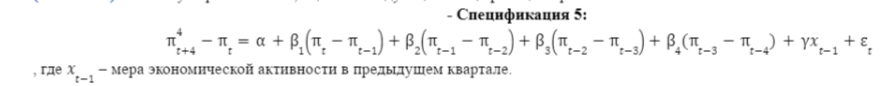

Создадим функцию для упрощения вычислений для разницы между инфляциями разных периодов.

In [ ]:
# Функция для вычисления разностей
def calculate_differences(df):
    df['(p_t - p_(t-1))'] = df['CPI, %'].diff()
    df['(p_(t-1) - p_(t-2))'] = df['CPI, %'].diff().shift()
    df['(p_(t-2) - p_(t-3))'] = df['CPI, %'].diff().shift(2)
    df['(p_(t-3) - p_(t-4))'] = df['CPI, %'].diff().shift(3)
    return df


Ссылка на процедуру применения фильтра Ходрика-Прескотта к квартальным данным по ВВП: https://asmquantmacro.com/2015/06/25/hodrick-prescott-filter-in-excel/comment-page-1/

При использовании фильтра получился потенциальный ВВП, для расчёта разрыва выпуска применялась соответствующая формула: https://cbr.ru/Content/Document/File/162037/1.pdf (презентация из официального доклада ЦБ РФ, слайд 2)

In [ ]:
df_CPI_5 = df_an[["Year", "Q", "CPI, %", "real GDP gap, %"]].copy()
df_CPI_5 = calculate_differences(df_CPI_5)
df_CPI_5.set_index('Q', inplace=True)
df_CPI_5['p_(t+4)-p_t'] = df_CPI_5['CPI, %'].shift(-4) - df_CPI_5['CPI, %']
df_CPI_sm_5 = df_CPI_5.iloc[4:-4]
per="real GDP gap, %"

X = df_CPI_sm_5[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))", per]]
X = sm.add_constant(X)
Y = df_CPI_sm_5['p_(t+4)-p_t']
model_5 = sm.OLS(Y, X).fit()
model_5.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     10.53
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           6.86e-08
Time:                        12:27:56   Log-Likelihood:                -320.05
No. Observations:                  91   AIC:                             652.1
Df Residuals:                      85   BIC:                             667.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6704      0.910      0.736      0.464      -1.140       2.481
(p_t - p_(t-1))         1.1578      0.337      3.441      0.001       0.489       1.827
(p_(t-1) - p_(t-2))    -0.1921      0.387     -0.497      0.621      -0.961       0.576
(p_(t-2) - p_(t-3))    -0.7531      0.384     -1.960      0.053      -1.517       0.011
(p_(t-3) - p_(t-4))    -0.5391      0.369     -1.460      0.148      -1.273       0.195
real GDP gap, %        -1.6469      0.367     -4.487      0.000      -2.377      -0.917
==============================================================================
Omnibus:                       14.621   Durbin-Watson:                   0.702
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.674
Skew:                           0.782   Prob(JB):                     8.81e-05
Kurtosis:                       4.575   Cond. No.                         4.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Спецификация 5 для каждого периода

In [ ]:
def fit_ols_model(df, start, end):
    # Выбираем нужный диапазон данных
    df_period = df.iloc[start:end]

    # Преобразуем данные в числовой формат
    df_period = df_period.apply(pd.to_numeric, errors='coerce')

    # Убираем первые и последние 4 строки
    df_period_sm = df_period.iloc[4:-4]

    # Определяем переменные X и Y
    X = df_period_sm[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))", per]]
    X = sm.add_constant(X)
    Y = df_period_sm['p_(t+4)-p_t']

    # Создаем и обучаем модель OLS
    model = sm.OLS(Y, X).fit()

    # Выводим результаты модели
    print(model.summary())

# Определяем диапазоны для каждого периода
periods = [(0, 33), (33, 65), (65, 81), (81, 99)]

# Для каждого периода вызываем функцию
for start, end in periods:
    fit_ols_model(df_CPI_5, start, end)


                            OLS Regression Results                            
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     2.729
Date:                Sun, 24 Nov 2024   Prob (F-statistic):             0.0506
Time:                        12:27:56   Log-Likelihood:                -45.484
No. Observations:                  25   AIC:                             103.0
Df Residuals:                      19   BIC:                             110.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.3864    

# Спецификация 6

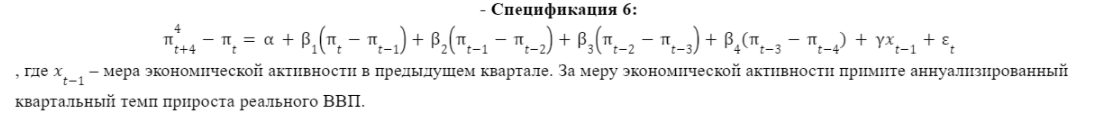

In [ ]:
# Обработка df_CPI_6
df_CPI_6 = df_an[["Year", "Q", "CPI, %", "real GDP growth, %"]].copy()
df_CPI_6 = calculate_differences(df_CPI_6)
df_CPI_6.set_index('Q', inplace=True)
df_CPI_6['p_(t+4)-p_t'] = df_CPI_6['CPI, %'].shift(-4) - df_CPI_6['CPI, %']
df_CPI_sm_6 = df_CPI_6.iloc[4:-4]
per="real GDP growth, %"

X = df_CPI_sm_6[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))", per]]
X = sm.add_constant(X)
Y = df_CPI_sm_6['p_(t+4)-p_t']
model_6 = sm.OLS(Y, X).fit()
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     7.450
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           7.76e-06
Time:                        12:27:56   Log-Likelihood:                -325.46
No. Observations:                  91   AIC:                             662.9
Df Residuals:                      85   BIC:                             678.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0563      1.023      0.055      0.956      -1.977       2.090
(p_t - p_(t-1))         0.6824      0.383      1.783      0.078      -0.079       1.443
(p_(t-1) - p_(t-2))    -0.1781      0.410     -0.434      0.665      -0.994       0.637
(p_(t-2) - p_(t-3))    -0.8958      0.406     -2.209      0.030      -1.702      -0.089
(p_(t-3) - p_(t-4))    -0.8617      0.389     -2.216      0.029      -1.635      -0.089
real GDP growth, %      0.1459      0.050      2.892      0.005       0.046       0.246
==============================================================================
Omnibus:                       15.565   Durbin-Watson:                   0.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.889
Skew:                           0.928   Prob(JB):                     0.000130
Kurtosis:                       4.127   Cond. No.                         24.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Спецификация 6 для каждого периода:

In [ ]:
# Для каждого периода вызываем функцию
for start, end in periods:
    print(fit_ols_model(df_CPI_6, start, end))

                            OLS Regression Results                            
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     2.787
Date:                Sun, 24 Nov 2024   Prob (F-statistic):             0.0472
Time:                        12:27:56   Log-Likelihood:                -45.374
No. Observations:                  25   AIC:                             102.7
Df Residuals:                      19   BIC:                             110.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.5782    

За меру Экономической активности мы приняли Индекс Предпринтмательских ожиданий. В данном ответе будет представлено обоснование использования BCI для построения модели инфляционных ожиданий в Великобритании.

▎1. Определение BCI

BCI — это индекс, который отражает уверенность бизнеса в экономической ситуации, и включает в себя мнения о текущих и будущих экономических условиях. Он может служить важным индикатором для анализа инфляционных ожиданий, так как уверенность бизнеса напрямую влияет на инвестиционные решения, потребление и, следовательно, на уровень цен.

▎2. Связь между BCI и инфляционными ожиданиями

• Корреляция: Исследования показывают, что высокие уровни BCI часто коррелируют с ростом инфляционных ожиданий. Когда бизнес уверенно смотрит в будущее, он склонен повышать цены на свои товары и услуги, что может привести к увеличению инфляции. (Ссылка на статью: https://www.businesstimes.com.sg/international/uk-consumer-confidence-edges-budget-gloom-fades)

  
• Прогнозирование: BCI может служить опережающим индикатором инфляции. Увеличение уверенности бизнеса может предшествовать росту цен, что делает BCI полезным инструментом для прогнозирования инфляционных тенденций.

▎3. Преимущества использования BCI (Ссылка на статью: [Côté A. Inflation, Expectations and Monetary Policy //Methods. – 2024.](https://www.shs-conferences.org/articles/shsconf/abs/2019/06/shsconf_m3e22019_06003/shsconf_m3e22019_06003.html))

• Доступность данных: Данные по BCI обычно собираются регулярно и доступны для анализа. Это позволяет строить модели на основе актуальной информации.

  
• Многофакторный подход: BCI учитывает мнение различных участников рынка, что позволяет получить более полное представление о состоянии экономики и инфляционных ожиданиях.

• Адаптивность: Индекс можно адаптировать под специфические экономические условия Великобритании, учитывая местные особенности и изменения в политике.


# Спецификация 7

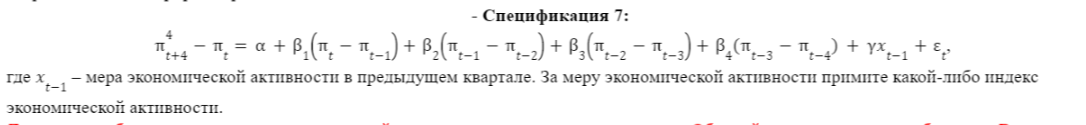

In [ ]:
# Обработка df_CPI_7
df_CPI_7 = df_an[["Year", "Q", "CPI, %", "BCI, %"]].copy()
df_CPI_7 = calculate_differences(df_CPI_7)
df_CPI_7.set_index('Q', inplace=True)
df_CPI_7['p_(t+4)-p_t'] = df_CPI_7['CPI, %'].shift(-4) - df_CPI_7['CPI, %']
df_CPI_sm_7 = df_CPI_7.iloc[4:-4]
per="BCI, %"

X = df_CPI_sm_7[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))", per]]
X = sm.add_constant(X)
Y = df_CPI_sm_7['p_(t+4)-p_t']
model_7 = sm.OLS(Y, X).fit()
model_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     5.679
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           0.000144
Time:                        12:27:56   Log-Likelihood:                -328.88
No. Observations:                  91   AIC:                             669.8
Df Residuals:                      85   BIC:                             684.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.7716      1.025      0.753      0.454      -1.266       2.809
(p_t - p_(t-1))         1.2192      0.385      3.163      0.002       0.453       1.986
(p_(t-1) - p_(t-2))    -0.2259      0.430     -0.526      0.600      -1.080       0.628
(p_(t-2) - p_(t-3))    -0.9922      0.423     -2.347      0.021      -1.833      -0.152
(p_(t-3) - p_(t-4))    -0.7334      0.404     -1.816      0.073      -1.537       0.070
BCI, %               2.116e-09   1.67e-09      1.267      0.209   -1.21e-09    5.44e-09
==============================================================================
Omnibus:                       19.105   Durbin-Watson:                   0.617
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.116
Skew:                           0.971   Prob(JB):                     2.13e-06
Kurtosis:                       4.765   Cond. No.                     6.56e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.56e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Спецификация 7 для каждого периода:

In [ ]:
# Для каждого периода вызываем функцию
for start, end in periods:
    fit_ols_model(df_CPI_7, start, end)

                            OLS Regression Results                            
Dep. Variable:            p_(t+4)-p_t   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     3.005
Date:                Sun, 24 Nov 2024   Prob (F-statistic):             0.0365
Time:                        12:27:56   Log-Likelihood:                -44.967
No. Observations:                  25   AIC:                             101.9
Df Residuals:                      19   BIC:                             109.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.4243    

# (7) Результаты оценки
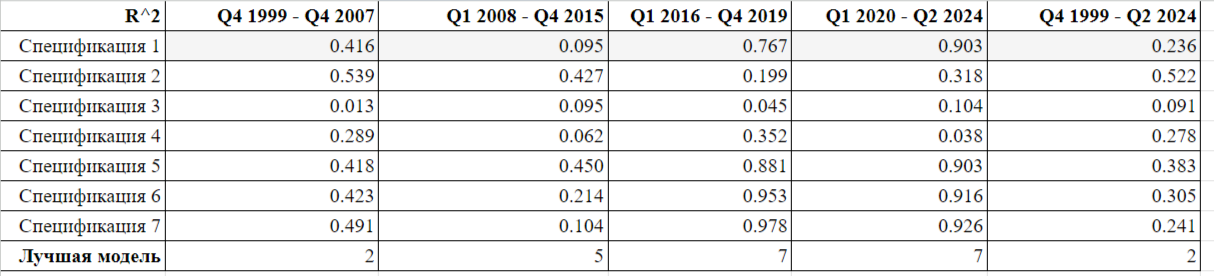

В представленной сводной таблице приведены значения коэффициента детерминации  R²  для различных спецификаций, разобранных в данной работе, примененных к данным в четырех периодах и суммарно за все периоды. Коэффициент  R²  позволяет оценить, насколько хорошо каждая модель объясняет вариацию зависимой переменной, в данном случае — инфляции.

**1. Общий обзор:** Наиболее высокие значения  R²  наблюдаются у Спецификации 7 в периоде с 2016-2019 года, что свидетельствует о ее способности наиболее точно предсказывать изменения инфляции в безкризисных ситуациях. Наихудший результат был зафиксирован в 1999-2007 годах, где  R² = 0.013.

**2. Сравнение моделей:**

   • Спецификация 2 демонстрирует высокие значения  R²  по многим периодам, что указывает на её превосходство в объяснении динамики инфляции.

   • Спецификация 3 демонстрирует наихудшие значения по всем периодам, что говорит о том, что эта модель не так эффективно учитывает временные зависимости и изменения в данных.

   • Спецификации 6 и 7 демонстрируют схожие показатели, что свидетельствут о похожем влиянии Разрыва инфляции и Уровня Предпринимательской уверенности, однако спецификация 7 является более точной.

**3. Заключение:** На основании представленных данных можно сделать вывод о том, что Наивный прогноз и regression forecast с учётом BCI имеет наилучшее качество предсказания инфляции среди рассмотренных моделей. Это может быть обусловлено тем, что Наивный прогноз, свойственен обычному чеоловеку, что позволяет более точно захватывать динамику временных рядов и сезонные колебания. BCI в спецификации 7, как показатель экономической активности позволяет добиться большей точности, как фактор, оказывающий влияние на инфляцию.

# (8) Прогнозы инфляции на основе оцененных моделей и сравнительный анализ

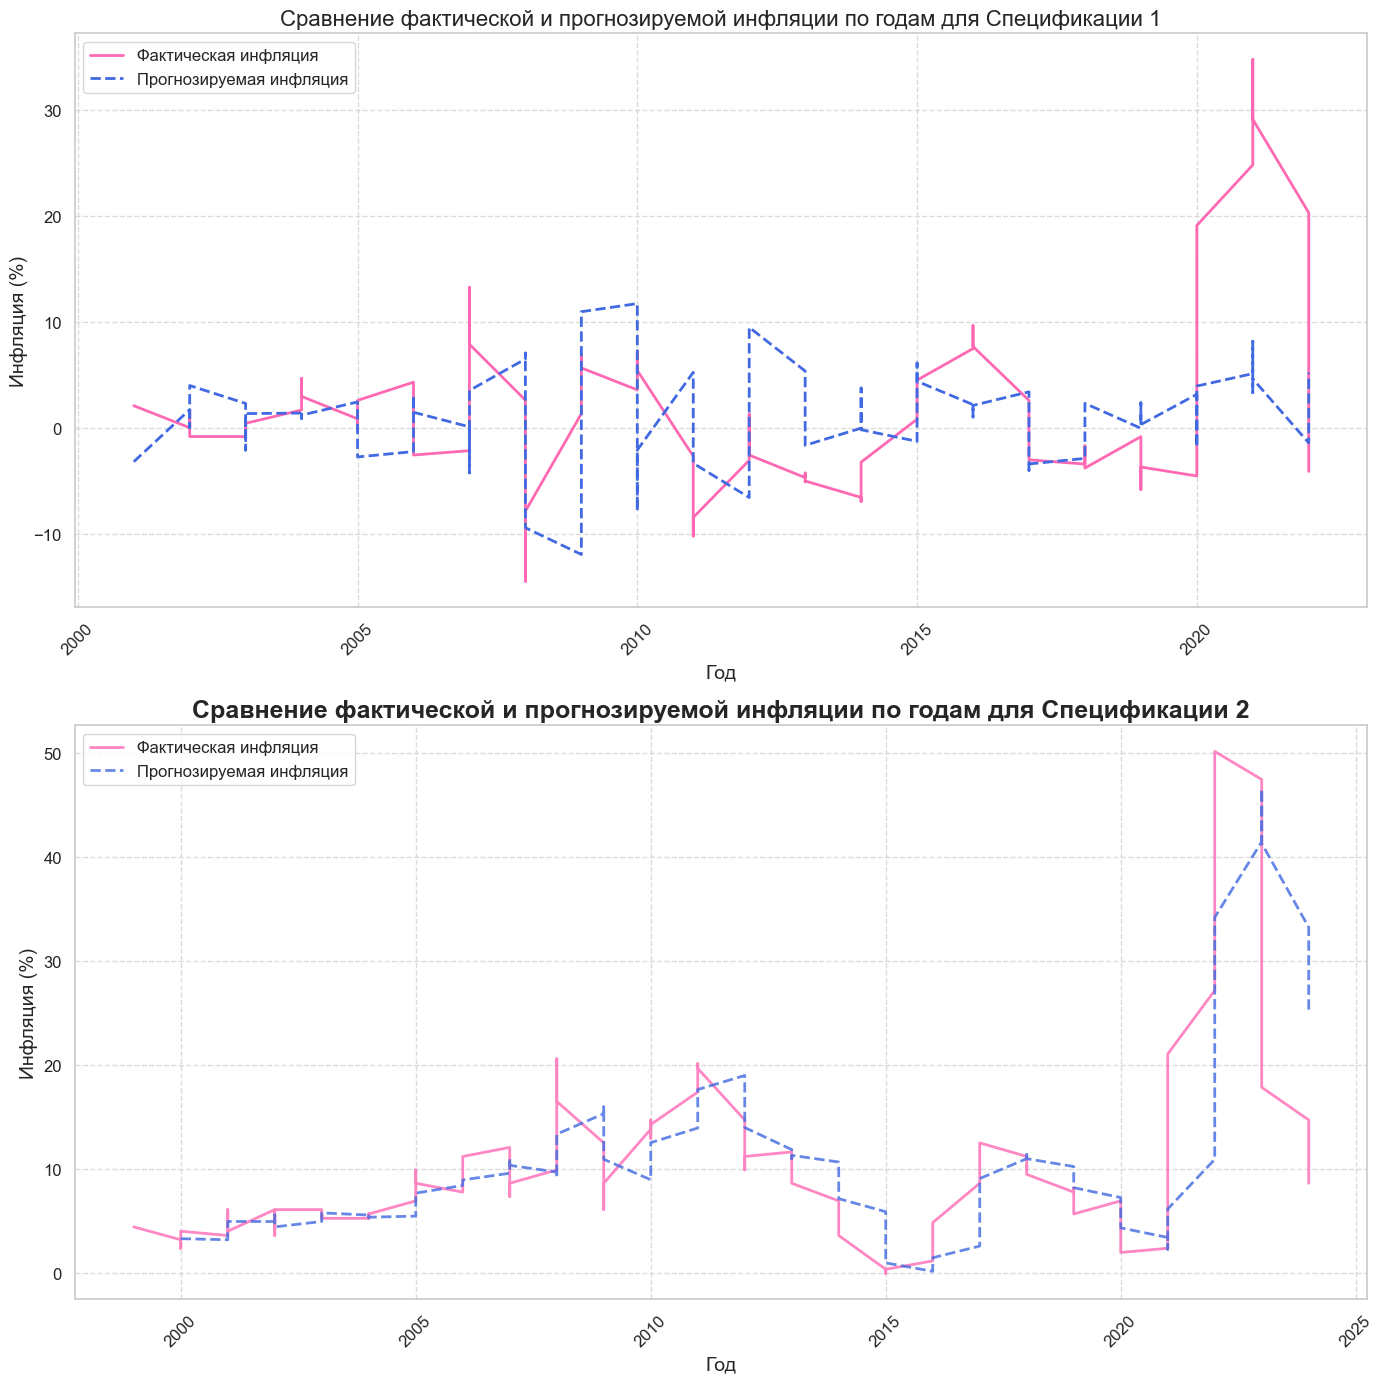

In [ ]:
# Устанавливаем стиль Seaborn для более красивых графиков
sns.set(style='whitegrid')

# Получаем фактические данные
actual_inflation = df_CPI_sm['p_(t+4)-p_t'].iloc[4:-4].reset_index(drop=True)

# Получаем годы для оси X
years = df_CPI_sm['Year'].iloc[4:-4].reset_index(drop=True)

# Получаем предсказания
X = df_CPI_sm[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))"]].iloc[4:-4]
X = sm.add_constant(X)
predictions_1 = model_1.predict(X)

# Предсказания второй модели
predictions_2 = df_CPI2['Forecast']

# Создаем график
plt.figure(figsize=(14, 14))  # Увеличиваем размер фигуры для двух графиков

# Первый график
plt.subplot(2, 1, 1)  # Два ряда, один столбец, первый график
plt.plot(years, actual_inflation, label='Фактическая инфляция', color='hotpink', markersize=8, linewidth=2)
plt.plot(years, predictions_1, label='Прогнозируемая инфляция', linestyle='--', color='royalblue', markersize=8, linewidth=2)

# Настройки первого графика
plt.title('Сравнение фактической и прогнозируемой инфляции по годам для Спецификации 1', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Инфляция (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Второй график
plt.subplot(2, 1, 2)  # Второй график
plt.plot(df_CPI2['Year'], df_CPI2['CPI, %'], label='Фактическая инфляция', color='hotpink', markersize=8, linewidth=2, alpha=0.8)
plt.plot(df_CPI2['Year'], predictions_2, label='Прогнозируемая инфляция', linestyle='--', color='royalblue', markersize=8, linewidth=2, alpha=0.8)

# Настройки второго графика
plt.title('Сравнение фактической и прогнозируемой инфляции по годам для Спецификации 2', fontsize=18, fontweight='bold')
plt.xlabel('Год', fontsize=14)
plt.ylabel('Инфляция (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


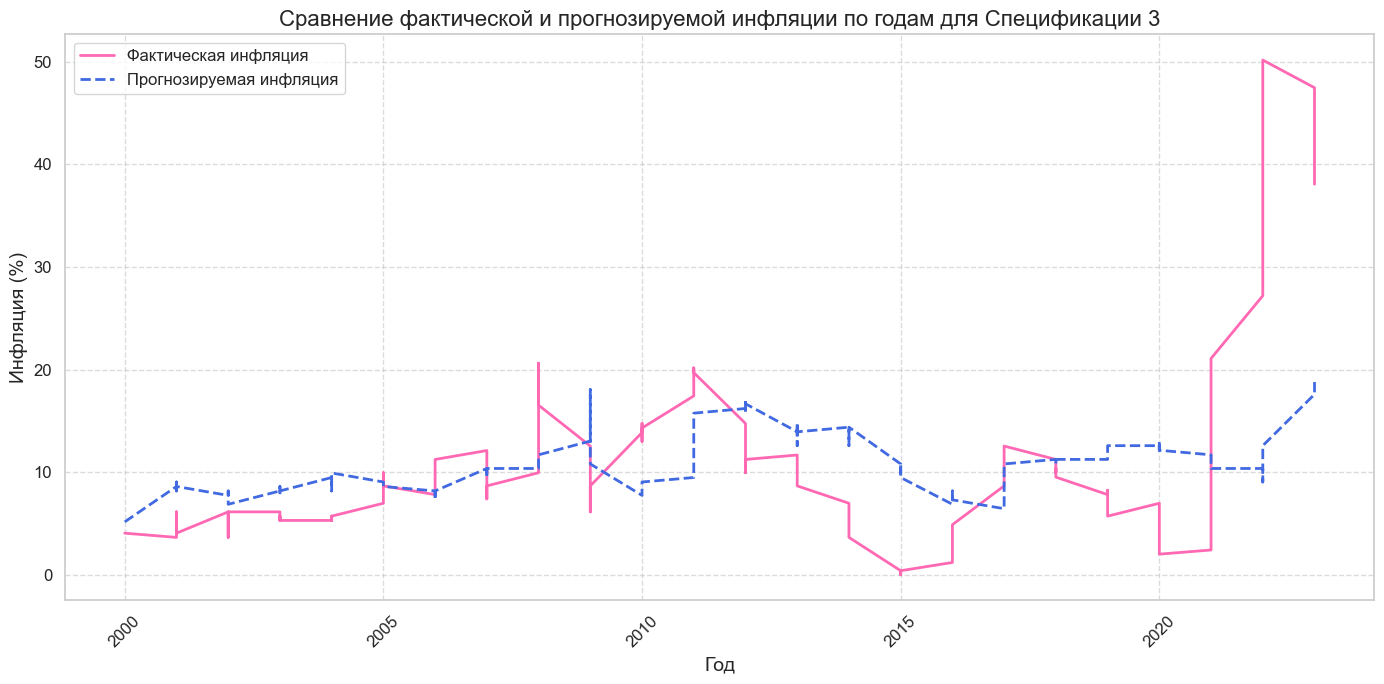

In [ ]:
#3я модель
# Вспоминаем модель
X = df_CPI_3_sm['Ep_(t-4)']
X = sm.add_constant(X)
Y = df_CPI_3_sm['CPI, %']

# Получаем предсказания
predictions = model_3.predict(X)

# Создаем график
plt.figure(figsize=(14, 7))

# Фактическая инфляция
plt.plot(df_CPI_3_sm['Year'], df_CPI_3_sm['CPI, %'],  label='Фактическая инфляция', color='hotpink', markersize=8, linewidth=2)

# Прогнозируемая инфляция
plt.plot(df_CPI_3_sm['Year'], predictions, label='Прогнозируемая инфляция', linestyle='--', color='royalblue', markersize=8, linewidth=2)

# Настройки графика
plt.title('Сравнение фактической и прогнозируемой инфляции по годам для Спецификации 3', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Инфляция (%)', fontsize=14)
plt.xticks(rotation=45)  # Поворот меток по оси X для лучшей читаемости
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)  # Улучшенная сетка
plt.tight_layout()  # Для улучшения компоновки графика

plt.show()

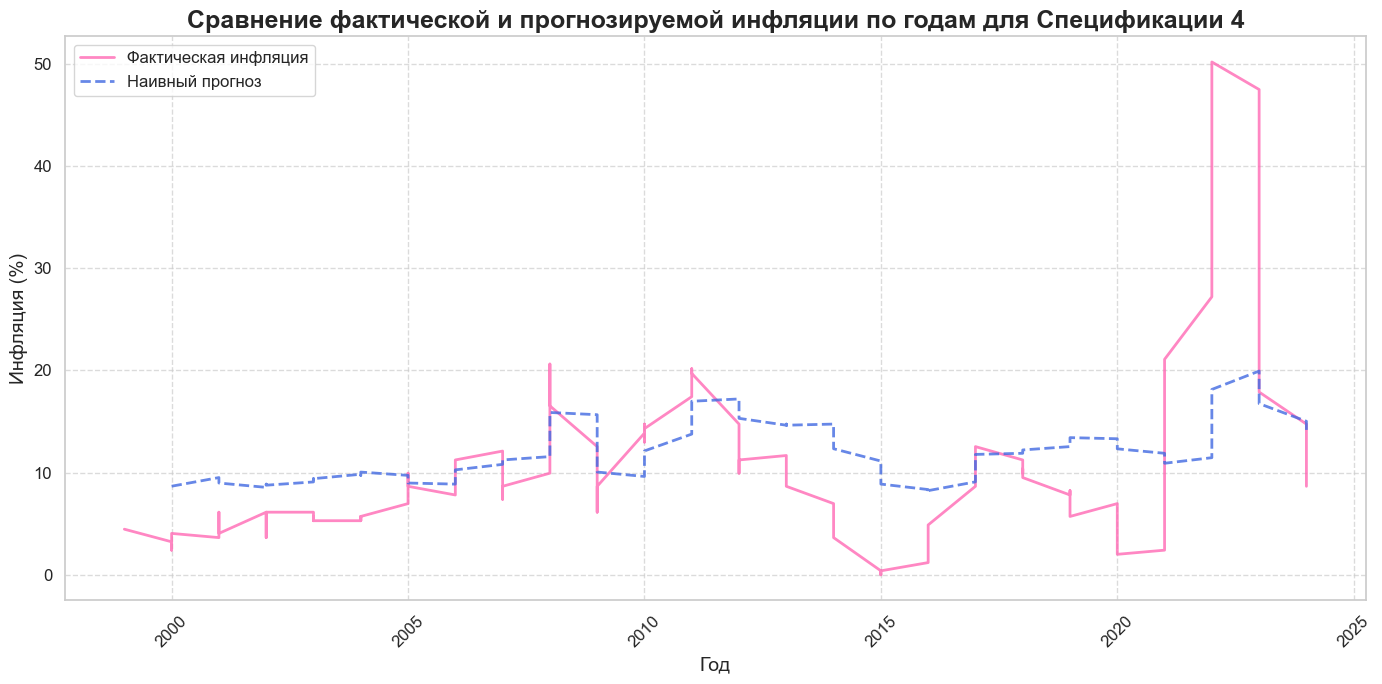

In [ ]:
#4я модель

# Проверим, что в данных есть нужные столбцы
if 'Year' in df_CPI_4.columns and 'CPI, %' in df_CPI_4.columns and 'naive forecast' in df_CPI_4.columns:
    plt.figure(figsize=(14, 7))

    # Фактическая инфляция
    plt.plot(df_CPI_4['Year'], df_CPI_4['CPI, %'],
             label='Фактическая инфляция',
             color='hotpink',
             markersize=8,
             linewidth=2,
             alpha=0.8)

    # Наивный прогноз
    plt.plot(df_CPI_4['Year'], df_CPI_4['naive forecast'],
             label='Наивный прогноз',
             linestyle='--',
             color='royalblue',
             markersize=8,
             linewidth=2,
             alpha=0.8)

    # Настройки графика
    plt.title('Сравнение фактической и прогнозируемой инфляции по годам для Спецификации 4', fontsize=18, fontweight='bold')
    plt.xlabel('Год', fontsize=14)
    plt.ylabel('Инфляция (%)', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)  # Поворот меток по оси X для лучшей читаемости
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12, loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)  # Улучшенная сетка

    # Убираем лишние отступы для улучшения компоновки графика
    plt.tight_layout()

    # Показать график
    plt.show()
else:
    print("В DataFrame отсутствуют необходимые столбцы.")

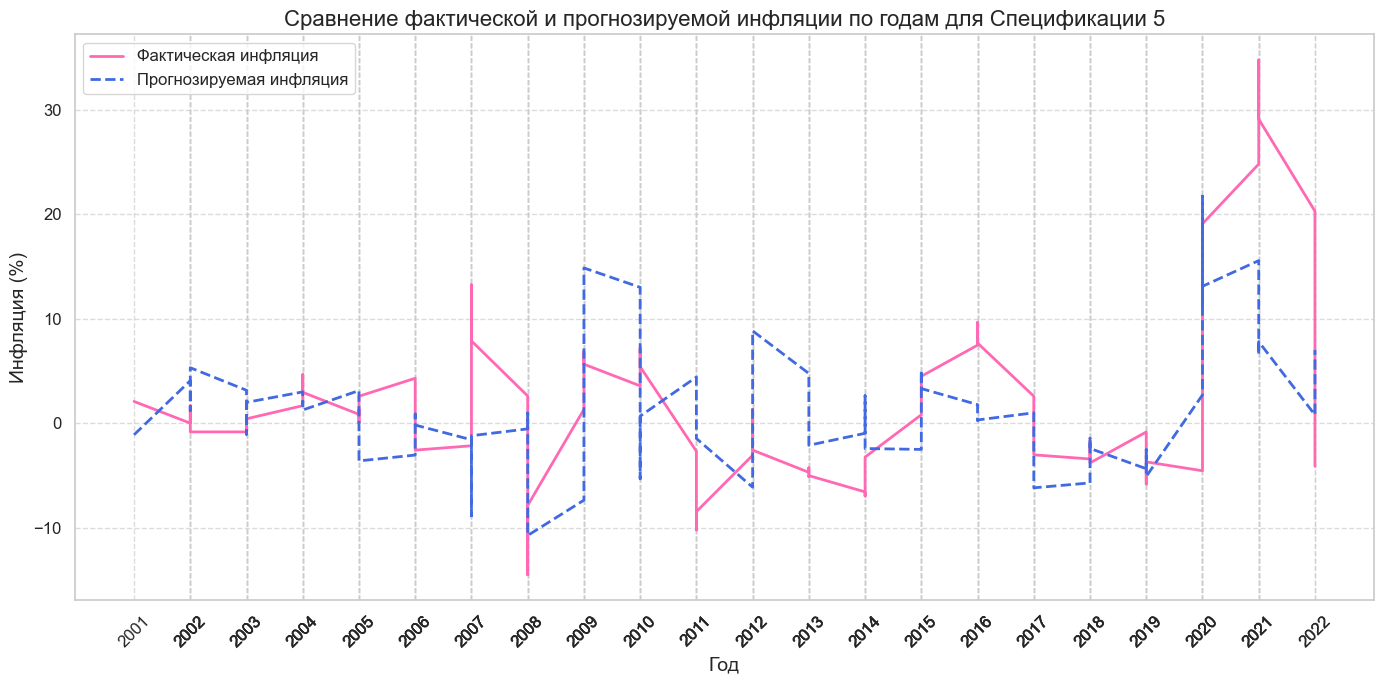

In [ ]:
# Устанавливаем стиль Seaborn для более красивых графиков
sns.set(style='whitegrid')

# Получаем фактические данные
actual_inflation = df_CPI_sm_5['p_(t+4)-p_t'].iloc[4:-4].reset_index(drop=True)

# Получаем годы для оси X
years = df_CPI_sm_5['Year'].iloc[4:-4].reset_index(drop=True)
per= "real GDP gap, %"

# Получаем предсказания
X = df_CPI_sm_5[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))", per]].iloc[4:-4]
X = sm.add_constant(X)
predictions = model_5.predict(X)

# Создаем график
plt.figure(figsize=(14, 7))

# Фактическая инфляция
plt.plot(years, actual_inflation, label='Фактическая инфляция', color='hotpink', markersize=8, linewidth=2)

# Прогнозируемая инфляция
plt.plot(years, predictions, label='Прогнозируемая инфляция', linestyle='--', color='royalblue', markersize=8, linewidth=2)

# Настройки графика
plt.title('Сравнение фактической и прогнозируемой инфляции по годам для Спецификации 5', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Инфляция (%)', fontsize=14)
plt.xticks(years, rotation=45)  # Поворот меток по оси X для лучшей читаемости
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)  # Улучшенная сетка
plt.tight_layout()  # Для улучшения компоновки графика

plt.show()

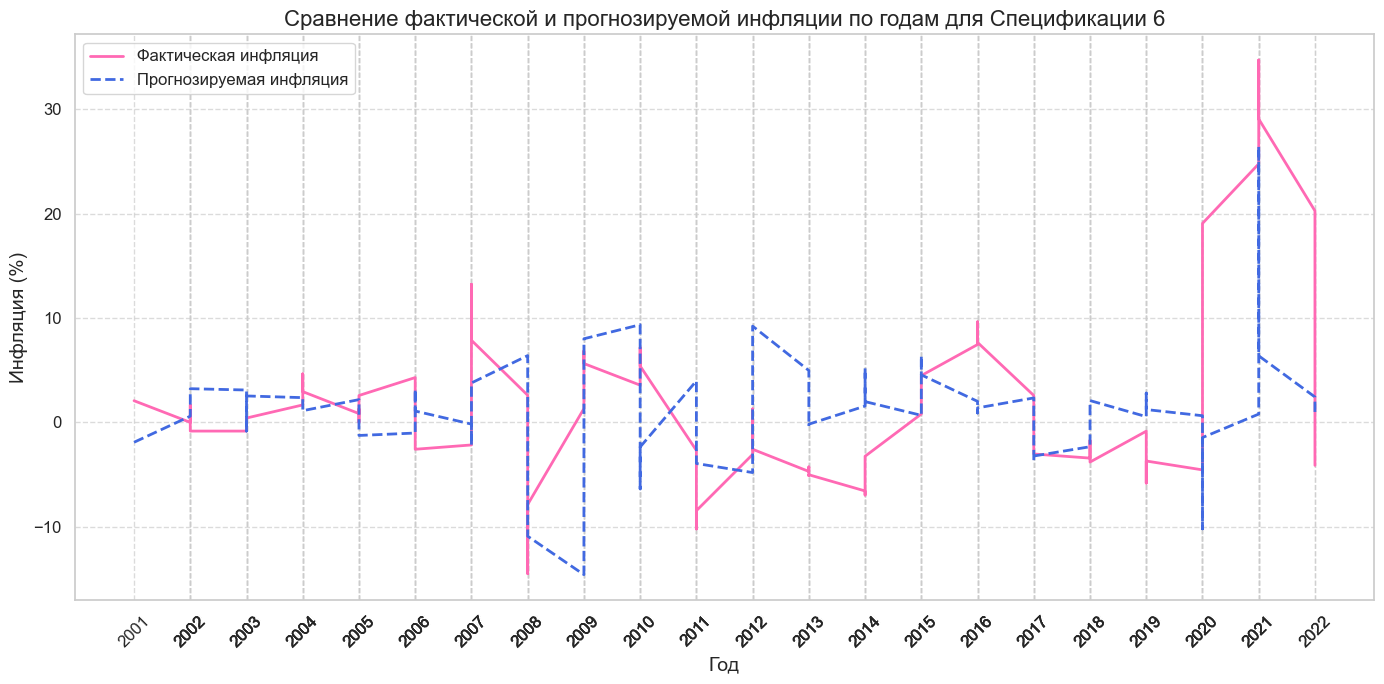

In [ ]:
#6я модель
# Получаем фактические данные
actual_inflation = df_CPI_sm_6['p_(t+4)-p_t'].iloc[4:-4].reset_index(drop=True)

# Получаем годы для оси X
years = df_CPI_sm_6['Year'].iloc[4:-4].reset_index(drop=True)

per="real GDP growth, %"

# Получаем предсказания
X = df_CPI_sm_6[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))", per]].iloc[4:-4]
X = sm.add_constant(X)
predictions = model_6.predict(X)

# Создаем график
plt.figure(figsize=(14, 7))

# Фактическая инфляция
plt.plot(years, actual_inflation, label='Фактическая инфляция', color='hotpink', markersize=8, linewidth=2)

# Прогнозируемая инфляция
plt.plot(years, predictions, label='Прогнозируемая инфляция', linestyle='--', color='royalblue', markersize=8, linewidth=2)

# Настройки графика
plt.title('Сравнение фактической и прогнозируемой инфляции по годам для Спецификации 6', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Инфляция (%)', fontsize=14)
plt.xticks(years, rotation=45)  # Поворот меток по оси X для лучшей читаемости
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)  # Улучшенная сетка
plt.tight_layout()  # Для улучшения компоновки графика

plt.show()

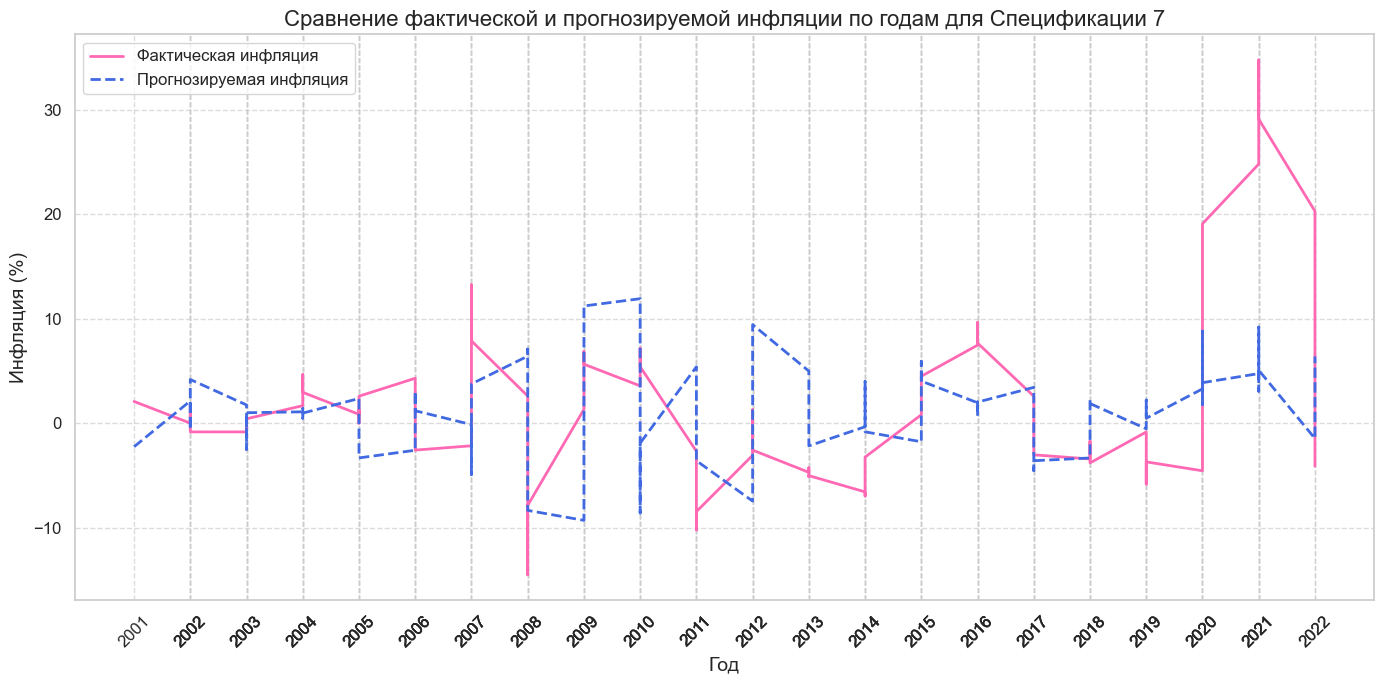

In [ ]:
#7я модель
# Получаем фактические данные
actual_inflation = df_CPI_sm_7['p_(t+4)-p_t'].iloc[4:-4].reset_index(drop=True)

# Получаем годы для оси X
years = df_CPI_sm_7['Year'].iloc[4:-4].reset_index(drop=True)

per="BCI, %"

# Получаем предсказания
X = df_CPI_sm_7[["(p_t - p_(t-1))", "(p_(t-1) - p_(t-2))", "(p_(t-2) - p_(t-3))", "(p_(t-3) - p_(t-4))", per]].iloc[4:-4]
X = sm.add_constant(X)
predictions = model_7.predict(X)

# Создаем график
plt.figure(figsize=(14, 7))

# Фактическая инфляция
plt.plot(years, actual_inflation, label='Фактическая инфляция', color='hotpink', markersize=8, linewidth=2)

# Прогнозируемая инфляция
plt.plot(years, predictions, label='Прогнозируемая инфляция', linestyle='--', color='royalblue', markersize=8, linewidth=2)

# Настройки графика
plt.title('Сравнение фактической и прогнозируемой инфляции по годам для Спецификации 7', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Инфляция (%)', fontsize=14)
plt.xticks(years, rotation=45)  # Поворот меток по оси X для лучшей читаемости
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)  # Улучшенная сетка
plt.tight_layout()  # Для улучшения компоновки графика

plt.show()

**1. Сравнение моделей:** Прогнозы, полученные с помощью Спецификации 5 и 6, оказались наиболее близкими к фактическим значениям инфляции, в то время как Спецификации 3 и 4 продемонстрировала более значительное отклонение.

**2. Тенденции:** В целом все модели смогли уловить общую тенденцию изменения инфляции, однако в определенные периоды наблюдались значительные расхождения между прогнозами и фактическими данными, например,  в 2008, в 2014, 2020 и 2021 были замечены выбросы, связанные с пандемией, экономическими кризисами и неожиданными политическими событиями.

**3. Заключение:** В целом, результаты показывают, что модели могут служить полезным инструментом для прогнозирования инфляции в будущем, .

Таким образом, проведенный анализ подтверждает важность использования различных моделей для более точного прогнозирования экономических показателей, таких, например, как инфляция.


# (10) Бонус

Очистим данные от сезонности.

In [ ]:
df_an1=df_an.drop(df_an.columns[1], axis=1)
df_an1.set_index('Year', inplace=True)

# функция для удаления сезонности
def deseasonalize(series):
    decomposition = sm.tsa.seasonal_decompose(series, model='additive', period=4) # период равен количеству кварталов в году
    return series - decomposition.seasonal

for i in df_an1.columns:
    df_an1[i] = deseasonalize(df_an1[i])

df_an1.reset_index(inplace=True)
df_an1

,Year,"CPI, %","core CPI, %","inf exp,%","real GDP growth, %","real GDP gap, %","BCI, %"
0,1999,4.570902,1.717215,5.996564,19.322368,0.450548,5.748317e+06
1,2000,3.272729,0.506339,9.722328,21.947506,1.155010,5.185896e+07
2,2000,2.307010,-0.107471,9.938439,19.308459,0.879008,-1.413512e+08
3,2000,3.221390,-0.097856,9.047165,18.302236,0.070834,8.924129e+07
4,2000,4.158169,1.313000,9.382504,14.848716,-0.222048,2.316317e+06
...,...,...,...,...,...,...,...
94,2023,37.960984,30.478799,14.739576,-0.690828,3.517796,-1.413512e+08
95,2023,29.598505,28.062279,15.060456,2.071196,2.340944,8.882529e+07
96,2023,17.986114,23.053329,13.578455,-0.213788,1.006251,5.748317e+06
97,2024,14.786424,19.814721,12.896159,2.064681,1.002686,5.086056e+07


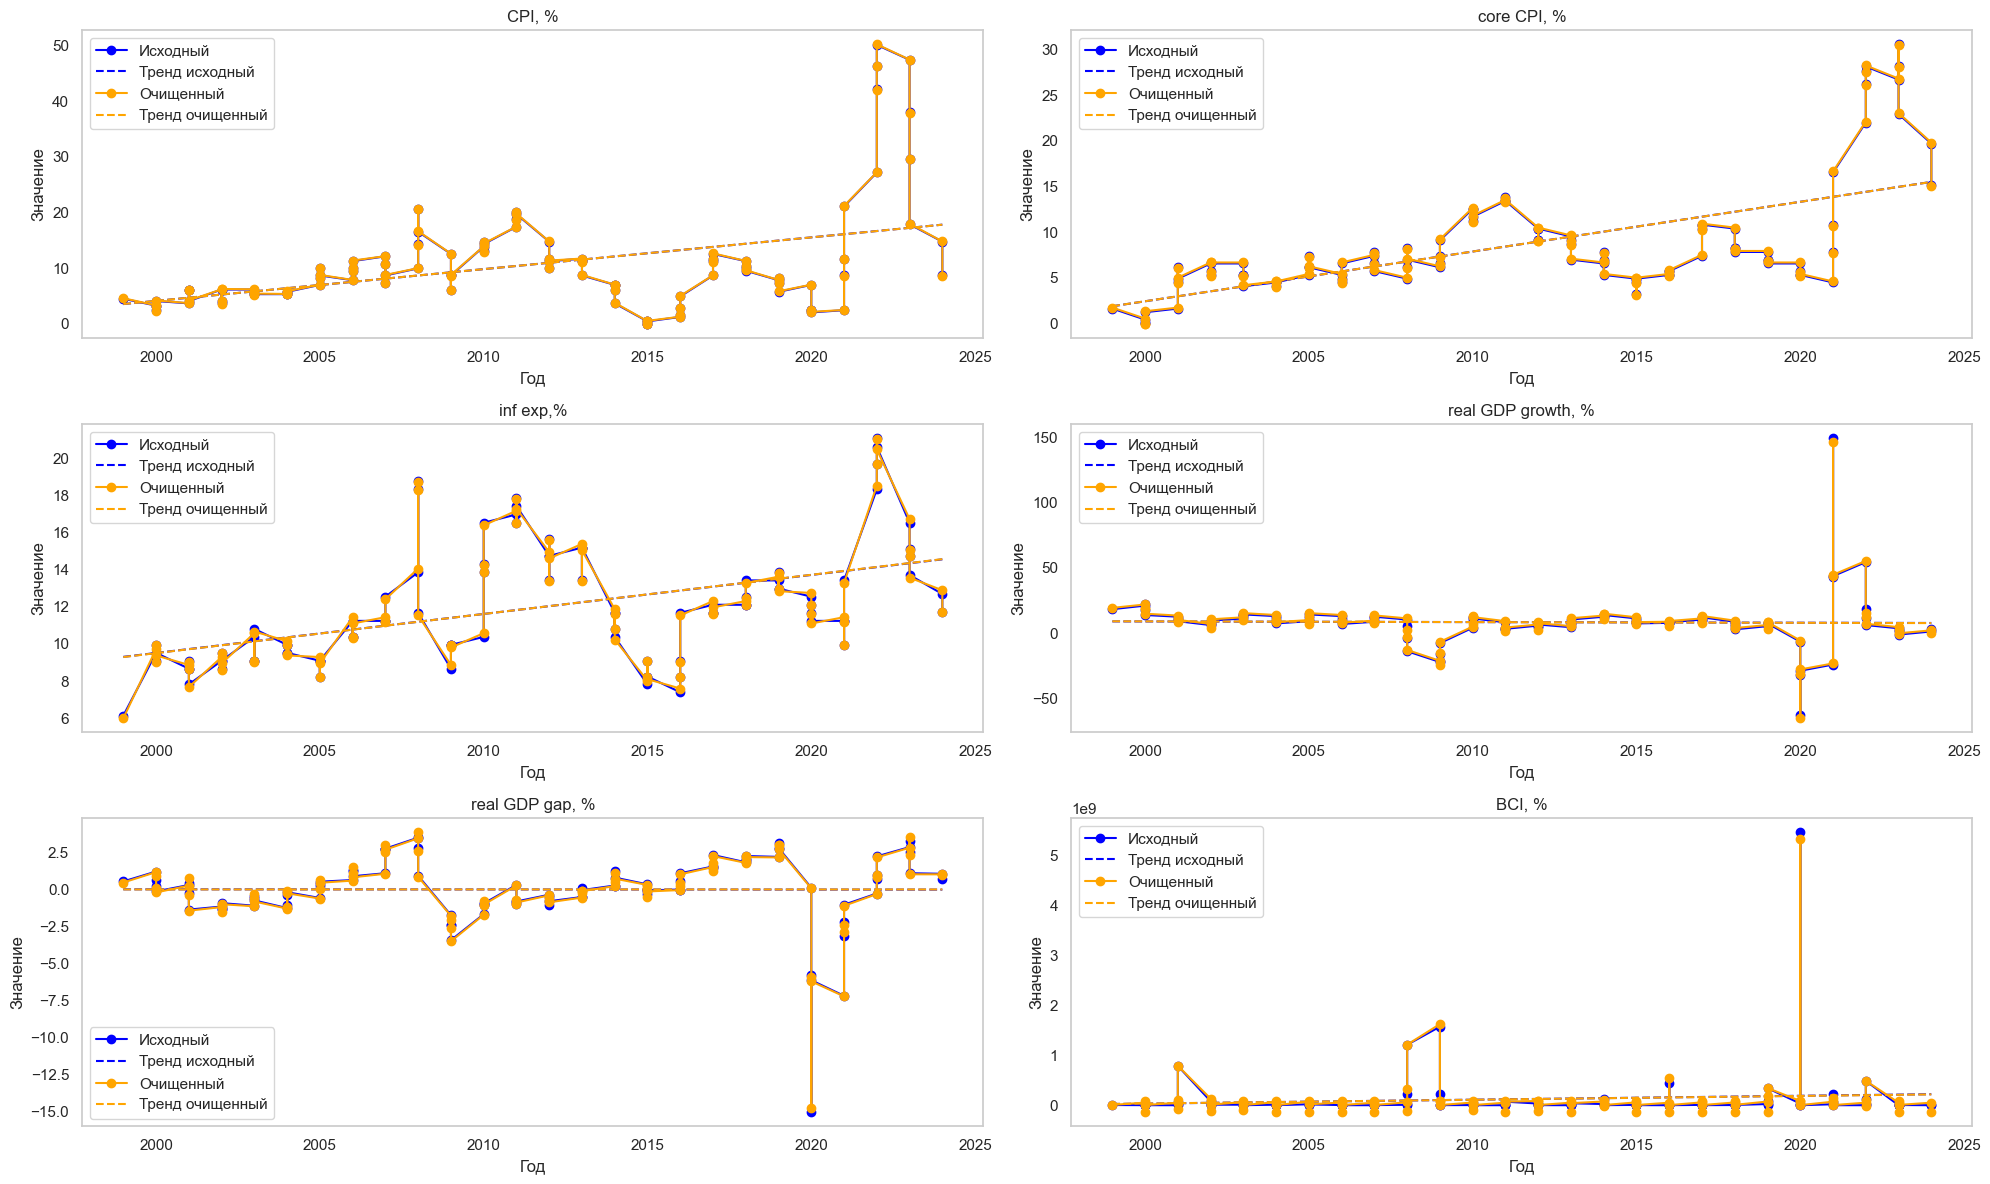

In [ ]:
df_an2=df_an.drop(df_an.columns[1], axis=1)
indicators = df_an2.columns[1:]  #количество показателей
num_indicators = len(indicators)

n_cols = 2
n_rows = (num_indicators + n_cols - 1) // n_cols
plt.figure(figsize=(20, 12))
# построение графиков для каждого показателя
for i, indicator in enumerate(indicators):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(df_an2['Year'], df_an2[indicator], marker='o', label='Исходный', color='blue')
    z_original = np.polyfit(df_an2['Year'], df_an2[indicator], 1)
    p_original = np.polyval(z_original, df_an2['Year'])
    plt.plot(df_an2['Year'], p_original, color='blue', linestyle='--', label='Тренд исходный')

    plt.plot(df_an1['Year'], df_an1[indicator], marker='o', label='Очищенный', color='orange')
    z_cleaned = np.polyfit(df_an1['Year'], df_an1[indicator], 1)
    p_cleaned = np.polyval(z_cleaned, df_an1['Year'])
    plt.plot(df_an1['Year'], p_cleaned, color='orange', linestyle='--', label='Тренд очищенный')

    plt.title(indicator)
    plt.xlabel('Год')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

На основе визуализации можно сделать вывод, что очищенные от сезонности данные лучше описываются трендом для каждого показателя, что означает, что очистка от сезонности прошла успешно: данные стали более предсказуемыми, повысилась точность.

Проверим исходные временные ряды на наличие единичного корня с.

Проверим исходные временные ряды на наличие единичного корня для выявления стационарности с помощью теста Дикки-Фуллера.

In [ ]:
df_an3=df_an2.iloc[:, 1:]

# функция для выполнения теста Дики-Фуллера
def check_stationarity(series):
    result = adfuller(series)
    return result[1]  # возвращаем p-value

# cоздаем новый датафрейм для хранения результатов
res = pd.DataFrame(columns=['Series', 'p-value', 'Stationarity'])

for i in df_an3.columns:
    p_value = check_stationarity(df_an2[i])
    stationarity = 'Stationary' if p_value < 0.05 else 'Non-Stationary'
    row_dict = {'Series': i, 'p-value': p_value, 'Stationarity': stationarity}
    res.loc[len(res)] = row_dict

res

,Series,p-value,Stationarity
0,"CPI, %",7.553862e-01,Non-Stationary
1,"core CPI, %",8.279222e-01,Non-Stationary
2,"inf exp,%",2.210959e-02,Stationary
3,"real GDP growth, %",6.202442e-08,Stationary
4,"real GDP gap, %",3.078457e-04,Stationary
5,"BCI, %",6.164049e-16,Stationary


Временные ряды по CPI и core CPI не стационарны, для них будем рассчитывать первые разности.

In [ ]:
df_an3['Diff_TS_CPI'] = df_an3['CPI, %'].diff()
df_an3['Diff_TS_core_CPI'] = df_an3['core CPI, %'].diff()


print("\nDataFrame с первыми разностями:")
df_an4=df_an3.iloc[:, -2:]
df_an4['Year']=df_an2['Year'].iloc[:len(df_an4)].values
df_an4["Q"]=df_an['Q'].iloc[:len(df_an4)].values
df_an4 = df_an4[['Year', 'Q', 'Diff_TS_CPI', 'Diff_TS_core_CPI']]
df_an4


DataFrame с первыми разностями:


,Year,Q,Diff_TS_CPI,Diff_TS_core_CPI
0,1999,Q4,NaN,NaN
1,2000,Q1,-1.234529,-1.209025
2,2000,Q2,-0.816919,-0.396600
3,2000,Q3,0.816919,0.000000
4,2000,Q4,0.821796,1.201411
...,...,...,...,...
94,2023,Q2,-9.402047,3.865493
95,2023,Q3,-8.459940,-2.426135
96,2023,Q4,-11.727374,-5.218395
97,2024,Q1,-3.136046,-3.236758
